In [ ]:
# https://stackoverflow.com/questions/49429585/how-to-change-the-background-color-of-a-single-cell-in-a-jupyter-notebook-jupy
from IPython.core.magic import register_line_magic
from IPython.display import HTML, display
import json

@register_line_magic
def bg(color, cell=None):    
    script = (
        "var n = [this.closest('.cell,.jp-CodeCell')];"
        "n = n.concat([].slice.call(n[0].querySelectorAll('.input_area,.highlight,.jp-Editor')));"
        f"n.forEach(e=>e.style.background='{color}');"
        "this.parentNode.removeChild(this)"
    )
    display(HTML(f'<img src onerror="{script}" style="display:none">'))  

# **Integrated CA**:  
## Twitter API Data Analysis

*Lecturers:* Muhammad Iqbal, David McQuaid

*Student:* [2020491]

## **Data Understanding:**

### **Data Collection:**
#### **Data Source:**
**`Twitter API`**<br>
The Twitter API enables programmatic access to Twitter elements such as: Tweets, Direct Messages, Spaces, Lists, users etc.<br>

https://developer.twitter.com/en/docs/twitter-api

<hr>

#### **Datasets:** 
**`ProjectTweets`**<br>
Created using Twitter API.

#### Import Modules
The required packages are imported for analysis.

In [ ]:
 #!pip install plotly#==5.5.0

In [ ]:
# Import Modules
try:
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    import numpy as np
    
    import statistics as st # Statistical Module(in Standard Library)
    import researchpy as rp
    
    import warnings
    warnings.filterwarnings("ignore")
except ModuleNotFoundError:
    !pip install seaborn numpy matplotlib researchpy plotly

#### Loading the Datasets
Takes a couple of seconds to load in the dataset. Huge improvement from the minutes it took before initial cleaning.

In [ ]:
%%time
df = pd.read_csv("./Data/ProjectTweets.csv")#,encoding = 'utf-16-le',sep='\t')#latin'utf-16',on_bad_lines='skip')#,lineterminator='\n')#,encoding_errors='replace')#,error_bad_lines=False)#)encoding="windows-1252"
#df_iso = pd.read_excel("./Data/_ISO-3166.xlsx")#sheet_name=0, header=0, names=None, index_col=None, usecols=None)

#### **`Data Naming`**

In [ ]:
# Assigning row names to data without headers
cols = ["ids","date","flag","user","text"]
df = pd.read_csv('./Data/ProjectTweets.csv', header=None, names=cols)#, index_col="ids")
len(df)

### **Data Description:**
To analyse the data, I conducted initial analysis on the dataset that can be seen step-by-step below. 

In [ ]:
df['text'].describe()

#### Data Size & Dimensions: 
The data size of **1600000** entry meets the requirements of accurate model creation.

In [ ]:
# Dimensions
print("Row:{} x Columns:{}".format(df.shape[0],df.shape[1]))

#### Data Overview
The `head` and `tail` functions show the first and last N observations in the data set which gives a glimpse at the structure of the data.

In [ ]:
N = 5
display(df.head(N))
display(df.tail(N))

The `info` function depicts data about each variable in the data set as well as the dataset as a whole.
There are 3 columns and 1600000 rows. There are no missing values in the entire data.

In [ ]:
# verbose:full_summary   null_counts:show_NaN   memory_usage:Exact_Size  
df.info(verbose=True, null_counts=True,memory_usage='deep')

# Data Preprocessing

### **Preprocessing**

Error arises when trying to make **ids** the id of the dataframe.
So verification of possible duplication is required!
#### IDs Duplication?

In [ ]:
# There are 1685 non-uniquely identified texts!!
print(len(df.ids)-len(df.ids.unique()))

In [ ]:
df[df.duplicated(subset='ids', keep=False)].sort_values(by='ids', ascending=True)

It seems that the queries that have identical `ids` also have all their data duplicated. But still need to be verified.
#### Record Duplication?

In [ ]:
grouped = df.groupby('ids')

In [ ]:
# Identify duplicate rows with all columns the same
duplicate_rows = df[df.duplicated(keep=False)]

if duplicate_rows.empty:
    print("No duplicate rows with all columns the same!")
else:
    print("There are duplicate rows with all columns the same:")
    print(duplicate_rows)

The records with the same ids are duplicate records so these data's are removed.

In [ ]:
df.drop_duplicates(keep='last', inplace=True)
df.reset_index(drop=True, inplace=True)

#### Missing Data?

In [ ]:
df.isnull().sum()

#### **Irrelevant Data**
As seen below, the only value the `flag` variable has is NO_QUERY hence it can be removed. 

In [ ]:
df.flag.unique()

In [ ]:
df.drop('flag', axis=1, inplace=True)

The `ids` column is unnecessary for the analysis, since the best way to sort this data is with the date of the tweet and then indexing it accordingly without the need to store and handle large integer values (i.e. Big integers). 

Not to mention the different issues that may arise from big integers such as:
- **Memory Usage** which limits the capacity of the analysis
- **Performing arithmetic** operations slow down with increased bit size for calculations
- **Computation** Libraries/Functions might not be optimized for big integers, leading to slower computations or potential errors
- **Overflow** operations on big integers may cause overflow errors if arbitrary precision arithmetic not handled
- **Visualization** Big integers can cause issues with data visualization libraries, e.g. when generating charts & graphs. Also, Scaling Big integer axes might also lead to distorted visualizations.

For these reasons the `ids` column can be removed.

In [ ]:
df.drop('ids', axis=1, inplace=True)

#### Text Formatting
Text needs to be converted from object to string format to be analysed.

In [ ]:
# Converting 'text' column to string
df['text'] = df['text'].astype(str)  

#### Date Formatting

To be able to sort the data based on date, the date needs to be converted to `datetime format`. For this the  date string format needs to be processed.

In [ ]:
# Get sample e.g. 3rd indexed date
df.iloc[2:3].date

In [ ]:
# Date Format
#date_format = "%a %b %d %H:%M:%S %Z %Y"

#df['date'].apply(lambda x: datetime.strptime(x, date_format))

The Format of the date is:
- %a: Weekday abbreviated (e.g. Mon)
- %b: Month abbreviated (e.g Apr)
- %d: Day of the month as a zero padded number (e.g. 06)
- %H: Hour (24-hour) as a zero padded number (e.g. 22)
- %M: Minute as a zero padded number (e.g. 19)
- %S: Second as a zero padded number (e.g. 53)
- %Z: Time zone (e.g. PDT)
- %Y: Year (e.g. 2009)

When trying to use `datetime` library ValueError occurs due to the *PDT* and *PST* time zone abbreviations,  not being directly supported by the strptime() function. To handle such time zone abbreviations, I use the pytz library along with dateutil for parsing the date string.

In [ ]:
#!python.exe -m pip install --upgrade pip

In [ ]:
!pip install pytz python-dateutil

In [ ]:
#from datetime import datetime
import pytz
from dateutil import parser

In [ ]:
df.head(n=3)

##### `Setting Timezone to UTC`
Using the *tz_convert* method to make sure the timezone is set to UTC to avoid timezone related issues (possibly in e.g. plotting)

In [ ]:
# Takes a couple of minutes
df['date'] = df['date'].apply(lambda x: parser.parse(x).astimezone(pytz.utc))
df['date'] = df['date'].dt.tz_convert('UTC')

In [ ]:
df['date']

#### Data Sorting with Date
Reindexing the data by sorting based on date from oldest to most recent tweet.

In [ ]:
df.sort_values(by='date').reset_index(drop=True, inplace=True)

#### Store Processed Data
To save time with the analysis processed data is saved here to be used later.

In [ ]:
df2 = df.copy()

### Possible Scam & Irrelevant Data
Any tweet has the probability to contain malicious link to check its validity would take extensive analysis not to mention how it is an irrelevant data for the analysis to be conducted. For the these reasons it is removed for further analysis.

In [ ]:
import re

# Regular Expression Pattern (to find websites)
pattern = r'\b(?:https?://|www\.)\S+(?=\s|$)|\S+\.com\b'  # Match start: http,https,www. & end with'.com',before whitespace  

# Website Extraction from each row in the 'text' column
websites_list = df['text'].apply(lambda x: re.findall(pattern, x))

# List Flattening (removing null values & merge into one list)
websites = [website for sublist in websites_list for website in sublist]

print(websites)

In [ ]:
from collections import Counter
websites_counts = Counter(websites)

In [ ]:
websites_counts.most_common()

In [ ]:
# Remove URLs from 'text' column's each row
df.text = df.text.apply(lambda x: re.sub(pattern, '', x))

In [ ]:
# Checker
#[website for sublist in df['text'].apply(lambda x: re.findall(pattern, x)) for website in sublist]

In [ ]:
df

In [ ]:
# Count occurrences of a word in the 'text' for each date (only showing with result)
df['text'][df['text'].apply(lambda x: x.lower().count('school') > 0)]

### Duplicate Texts
Duplicate texts over a period of time may arise for a number of reasons such as:
- After cleaning the text from URLs it is possible that some might have become empty (i.e. text only had link). These need to be removed as they contain no information about the sentiment of the tweets. They are useful for initial analysis to check the users presence frequency.
- Users might follow a trend or have a strong emotion to certain topics, these can be left in to emphasis their sentimental impact on the community

In [ ]:
df[df.duplicated(subset='text', keep=False)].sort_values(by='text', ascending=True)

In [ ]:
# Removing leading & trailing whitespaces from 'text' (to show it as empty)
df.text = df.text.str.strip()

# Removing rows with empty 'text'
df = df[df['text'].notna() & (df['text'] != '')]

df.reset_index(drop=True, inplace=True)

In [ ]:
df[df.duplicated(subset='text', keep=False)].sort_values(by='text', ascending=True)

### HTML Character Entities
Having Entity names could affect the analysis for a number of reasons including:
- *Interpretation error* e.g. sentiment analysis may have the meaning of the text distorted
- *Tokenization Disruption* with possible incorrect word counts
- *ML* introducing additional features not contributing to text meaning could impact the *model*'s performance & generalization
- *Data Cleaning* HTML entities can be considered noise during text analysis
- ...

To avoid it these are removed from the text.

In [ ]:
# Replace HTML entities in the 'text' column
df['text'] = df['text'].str.replace('&gt;', '>', regex=True)
df['text'] = df['text'].str.replace('&lt;', '<', regex=True)
df['text'] = df['text'].str.replace('&amp;', '&', regex=True)

In [ ]:
!pip install beautifulsoup4

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
# Remove HTML entities in the 'text' column
df['text'] = df['text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

### Possible Inappropriate Texts
Throughout the preprocessing phase of the analysis I have found possible culprits of inappropriate texting behavior. Although this would need further analysis later on since talking about this topic does not necesarily imply bad faith but filtering this out is time consumming. Furthermore, it could shed light to a possible regular cyber attacks by certain menacing individuals. Additionally, even if an uncomfortable topic it can still hold sentimental value so might be left in for the analysis.

In [ ]:
pattern = r'\bNSFW\b|\bsex\b'

df[df['text'].str.contains(pattern, case=False, regex=True)]

In [ ]:
df.loc[1095400, 'text']

# TEXT ANALYSIS

### Dataset's Timespan
Calculating the span by subtracting the earliest from the latest date.
Below, it shows the dataset contains 79 days, 12 hours, 8 minutes and 46 seconds of tweets.

In [ ]:
# Timespan of the Dataset
df['date'].max() - df['date'].min()

### Hashtags
Checking the keywords used by users.

In [ ]:
import re

pattern = r'#(\w+)'
hashtags_list = [mention for sublist in df['text'].apply(lambda x: re.findall(pattern, x)) for mention in sublist]
#mentions = [mention for sublist in mentions_list for mention in sublist]

In [ ]:
from collections import Counter
hashtags_counts = Counter(hashtags_list)

In [ ]:
#sorted(hashtags_counts)

# Descending Order
hashtags_counts.most_common()

# Ascending Order
#sorted(hashtags_counts.items(), key=lambda x: x[1])

#### `Wordcloud`

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud object Creation
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(hashtags_counts)

# Plot Creation
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Hashtags used by Users', size=20)

# Plot Showing
plt.show()

### Popular Users
Checking the users popularly tweeted by users.

In [ ]:
import re

pattern = r'@(\w+)'
user_list = [mention for sublist in df['text'].apply(lambda x: re.findall(pattern, x)) for mention in sublist]

In [ ]:
from collections import Counter
user_counts = Counter(user_list)

In [ ]:
#sorted(user_counts)

# Descending Order
user_counts.most_common()

# Ascending Order
#sorted(user_counts.items(), key=lambda x: x[1])

#### `Wordcloud`

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud object Creation
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(user_counts)

# Plot Creation
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Popular Users tweeted by Users', size=20)

# Plot Showing
plt.show()

### 20 Top Tweeters

In [ ]:
# 20 Top Tweeters
df['user'].value_counts().head(20)

In [ ]:
# 20 Top Tweeters over the span of dataset
tweeters = df['user'].value_counts().head(20)

# Seaborn Style
sns.set(style="whitegrid")

# Bar plot using Seaborn
plt.figure(figsize=(15, 10))
ax = sns.barplot(x=tweeters.index, y=tweeters.values, color='darkgreen')
plt.title('20 Top Tweeters',fontsize=30, color='green', backgroundcolor='honeydew')
plt.xlabel('Tweeters')
plt.ylabel('Number of Tweets')

ax.set_xticklabels([item for item in tweeters.index], rotation=45)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 20 Least Tweeters

In [ ]:
# 20 Least Tweeters
df['user'].value_counts().tail(20)

In [ ]:
# 20 Least Tweeters over the span of dataset
tweeters = df['user'].value_counts().tail(20)

# Seaborn Style
sns.set(style="whitegrid")

# Bar plot using Seaborn
plt.figure(figsize=(15, 10))
ax = sns.barplot(x=tweeters.index, y=tweeters.values, color='maroon')
plt.title('20 Least Tweeters',fontsize=30, color='red', backgroundcolor='lavenderblush')
plt.xlabel('Tweeters')
plt.ylabel('Number of Tweets')

ax.set_xticklabels([item for item in tweeters.index], rotation=45)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Average Number of Tweets per Tweeter (over a span of 79 days)

In [ ]:
# Average Number of Tweets per Tweeter (over a span of 79 days)
df['user'].value_counts().mean()

### Average Number of tweets per day (over a span of 79 days)

In [ ]:
# Average number of tweets per day
df.groupby(df['date'].dt.date).size().mean()

### Total number of tweets per day

In [ ]:
# Total number of tweets per day
df.groupby(df['date'].dt.date).size()

In [ ]:
# DATEFORMATTER NOT WORKING --> from matplotlib.dates import DateFormatter
# USING APPLY FUNCTION

# Plot the number of tweets per day
plt.figure(figsize=(15, 5))

ax = df.groupby(df['date'].dt.date).size().plot(kind='bar',
                                                color='indigo',edgecolor='plum', alpha=0.5)
plt.title('Tweet Distribution',color= "goldenrod", fontsize=22,weight='bold',fontname="Times New Roman") 
plt.xlabel('Date')
plt.ylabel('Number of Tweets Per Day')

# Format tick labels to show only month and day
ax.set_xticklabels([item.strftime('%b %d') for item in df.groupby(df['date'].dt.date).size().index], rotation=45)

plt.grid(color='gray', linestyle='--', linewidth=0.5)

#date_form = DateFormatter("%d %b")
#ax.xaxis.set_major_formatter(date_form)

plt.xticks(rotation=45)
plt.tight_layout()

#plt.suptitle("Tweet Distribution", color= "gold", fontsize=22,weight='bold',fontname="Times New Roman")

plt.show()

### Regular Users only
If over the span of 79 days, a user hasn't at least tweeted 79 tweets then they are not considered regular i.e. equating to at least one tweet per day.
Below it shows that out of a total of **659765** users only **322** are regular users.

In [ ]:
df.user.value_counts()[df['user'].value_counts() >= 79]

In [ ]:
len(df.user.unique())

### Users' Tweeting Pattern

In [ ]:
print("Nunber of Tweets per day")
display(df.groupby(["user",df['date'].dt.month, df['date'].dt.day]).count())#.sort_values()#["Year"],ascending=True)
print("Tweets per day")
display(df.groupby(["user",df['date'].dt.month, df['date'].dt.day]).sum())#.sort_values()#["Year"],ascending=True)

### Users' Overall Statistics

In [ ]:
# User Statistics
df["user"].describe()

### Remove User names, Hashtags, Special Characters, Digits & Extra Spaces
To find the sentiment of the users hashtags and user names do not contribute to further analysis. So they are removed.

In [ ]:
# Function to clean the text column
def clean_text(text):
    # Removing Words starting with '#' or '@'
    text = re.sub(r'[@#]\w+\s*', ' ', text)
    
    # Removing Special chars & Digits
    #text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Removing Special chars & Digits except apostrophe (used for contraction handling!!!)
    text = re.sub(r'[^a-zA-Z\s\']', '', text)
    
    # Lowercase Conversion
    text = text.lower()
    
    # Removing Extra Space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
df['cleaned_text'] = df['text'].apply(clean_text).astype(str)  

In [ ]:
df

In [ ]:
# BACKUP DATA!!!
df2 = df.copy()
#df = df2.copy()

#### `Check Empty texts` after preprocessing

In [ ]:
# Removing leading & trailing whitespaces from 'text' (to show it as empty)
df.text = df.text.str.strip()

# Removing rows with empty 'text'
df = df[df['text'].notna() & (df['text'] != '')]

df.reset_index(drop=True, inplace=True)

In [ ]:
# Check duplicates
df[df.duplicated(subset='text', keep=False)].sort_values(by='text', ascending=True)

### Change Date Format
For the analysis the time (hour,minute, second) the tweet was sent is irrelevant. Only the date is important hence the date is changed to only include the year, month and day of the tweet.

In [ ]:
# Formating 'date' column to 'YYYY-MM-DD'
#df['date'] = df['date'].dt.strftime('%Y-%m-%d') # CREATES ERROR column not recognized as datetime obj
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# BACKUP DATA!!!
#df2 = df.copy()
#df = df2.copy()

### Remove User Column
For the overall sentiment analysis it is irrelevant which user tweeted, the overall sentiment of the data is  crucial.

In [ ]:
df.drop("user", axis=1, inplace=True)

# Text Processing
Before any text analysis can be performed text processing needs to be done. Below are the techiques used.

## Expanding Contractions

For the efficiency of the next step, i.e. removing stopwords, it is crucial to expand the contractions to the groups of words that they represent. e.g. didn't to did not... Athough it is important to note that in the text some of these are missing apostrophe signs in the text so it needs to be handled too.

In [ ]:
!pip install contractions

In [ ]:
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [ ]:
import re
import contractions
#import spacy

Using language model spaCy to tokenize the text and leverage its lemmatization feature to correctly handle contractions and missing apostrophes e.g. **thats** to **that is**.

In [ ]:
# Loading spaCy language model
#nlp = spacy.load("en_core_web_sm")

In [ ]:
# Function to expand contractions (including missing apostrophe)
def expand_contractions(text):
    # regex to add the missing apostrophes
    #text = re.sub(r"\b(\w+)(s|re)\b", r"\1 '\2", text)  
    return contractions.fix(text)

# Takes a couple minutes!!!!
# Apply contraction expansion function to the 'text' column
df['preprocessed_text'] = df['cleaned_text'].apply(expand_contractions)

In [ ]:
# BACKUP DATA!!!
#df2 = df.copy()
#df = df2.copy()

In [ ]:
df

## Removing Stopwords
Stopwords (e.g. the, and, is, of, in etc.) being commonly used words that generally don't carry meaning. I will remove them for a number of reasons:

- reduce `noise` (in text analysis)
- improve `efficiency` reducing word size to process speeding up algorithms and save memory
- better `interpretation` for topic modeling more meaningful and interpretable topics
    

It is important to consider how sometimes stopwords might be crucial for instance: in sentiment analysis some stopwords like **not** can change the meaning. In such cases, retaining certain stopwords.

Hence, I will retain stopwords 'no' and 'not' to presence the meaning.

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Defining stopwords with exceptions
stop_words = set(stopwords.words('english')) - {'no', 'not'}

def stopwords_removal_with_exception(text, exceptions):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words or word in exceptions]
    return ' '.join(filtered_words)

In [ ]:
df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: stopwords_removal_with_exception(x, {'no', 'not'}))

In [ ]:
df

## Text Tokenization & Stemming/Lemmatization
Using Porter stemming algorithm, to Stem the text has resulted in incorrect stemming such as his became hi, body became bodi. For this reason I decided to use lemmatization to increase the chances to produce a valid base form (i.e. lemma) of the words.

In [ ]:
import re

from nltk.stem import WordNetLemmatizer
#from nltk.stem import PorterStemmer

from nltk.tokenize import word_tokenize

In [ ]:
def tokenize_and_lemmatize(text):
    # Tokenize the text
    words = word_tokenize(text)
    
    # Initialize stemmer
    #stemmer = PorterStemmer()
    # Stem words
    #stemmed_words = [stemmer.stem(word) for word in words] 
    #return ' '.join(stemmed_words)
    
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()    
    # Lemmatize words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]    
    return ' '.join(lemmatized_words)   

In [ ]:
# Takes a couple minutes!!!!
df['preprocessed_text'] = df['preprocessed_text'].apply(tokenize_and_lemmatize)

In [ ]:
# BACKUP DATA!!!
df2 = df.copy()
#df = df2.copy()

# Sentiment Labeling
Assigning sentiment labels to the text: positive, negative or neutral based on the sentiment expressed in the text. 

I will use the **VADER** sentiment analysis tool from the NLTK library, which is a pre-trained sentiment analysis models trained on large text datasets.



In [ ]:
#!pip install nltk

In [ ]:
import nltk
nltk.download('vader_lexicon') # used by SentimentIntensityAnalyzer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
# SentimentIntensityAnalyzer Initialisation
sia = SentimentIntensityAnalyzer()

# Assigning Sentiment Labels
def sentiment_label(text):
    
    sentiment_scores = sia.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    
    if compound_score >= 0.05:
        return 'positive'
    
    elif compound_score <= -0.05:
        return 'negative'
    
    else:
        return 'neutral'

# Apply sentiment labeling function to the 'text' column
df['sentiment'] = df['preprocessed_text'].apply(sentiment_label)

In [ ]:
df

In [ ]:
df2 = df.copy()

# Store & Load dataframe for Modelling
Since modeling is time consuming it is advisable to store the prepared data in order to avoid running through the code again and again when Kernel needs to be restarted or cleared.

In [1]:
# STORE
#PATH = './data/cleanedProjectTweets.csv'
#df.to_csv(PATH, index=False)  # Set index=False avoids saving row numbers as column

In [2]:
# LOAD!!!
import pandas as pd

df = pd.read_csv('./data/cleanedProjectTweets.csv')

In [3]:
# Set up datatypes

# Formating 'date' column to 'YYYY-MM-DD'
df['date'] = pd.to_datetime(df['date'])
#df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

df.drop('text', axis=1,inplace=True) #df['text'].astype('string')
df.drop('cleaned_text', axis=1,inplace=True) #df['cleaned_text'].astype('string')

df['preprocessed_text'] = df['preprocessed_text'].astype('string')
df['sentiment'] = df['sentiment'].astype('string')

#df.reset_index(drop=True, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598285 entries, 0 to 1598284
Data columns (total 3 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   date               1598285 non-null  datetime64[ns]
 1   preprocessed_text  1590126 non-null  string        
 2   sentiment          1598285 non-null  string        
dtypes: datetime64[ns](1), string(2)
memory usage: 36.6 MB


In [5]:
df.drop_duplicates(keep='last', inplace=True)
df.reset_index(drop=True, inplace=True)

#### `Check Empty texts` after preprocessing

In [6]:
# Removing leading & trailing whitespaces from 'text' (to show it as empty)
df.preprocessed_text = df.preprocessed_text.str.strip()

# Removing rows with empty 'text'
df = df[df['preprocessed_text'].notna() & (df['preprocessed_text'] != '')]

df.reset_index(drop=True, inplace=True)

In [7]:
# Filter out rows where 'TextColumn' has only one character or none
df = df[~df['preprocessed_text'].apply(lambda x: len(str(x)) <= 1)]
df.reset_index(drop=True, inplace=True)

In [8]:
df.drop_duplicates(subset=['preprocessed_text'],keep='last', inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
# Check duplicates
df[df.duplicated(subset='preprocessed_text', keep=False)].sort_values(by='preprocessed_text', ascending=True)

,date,preprocessed_text,sentiment


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1469845 entries, 0 to 1469844
Data columns (total 3 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   date               1469845 non-null  datetime64[ns]
 1   preprocessed_text  1469845 non-null  string        
 2   sentiment          1469845 non-null  string        
dtypes: datetime64[ns](1), string(2)
memory usage: 33.6 MB


# Model Training
After Processing the text data, training the sentiment analysis model can begin.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Smaller Data portion 
Using frac of the data to speed up experimentation

In [14]:
# smaller data portion faster experimentation
df_sample = df.sample(frac=0.0001, random_state=42)

## Train & Test Splitting

In [16]:
# Split the data into train and test sets
train_df, test_df = train_test_split(df_sample, test_size=0.2, random_state=42)

## Feature Extraction

In this phase, the text is converted into numerical features usable for training. I will use a common approach using the TF-IDF (Term Frequency-Inverse Document Frequency) representation.

In [17]:
# Feature extraction using TF-IDF with fewer features
tfidf_vectorizer = TfidfVectorizer(max_features=1000) # adjustable feature number (lower->less accurate but faster)


X_train = tfidf_vectorizer.fit_transform(train_df['preprocessed_text'])
y_train = train_df['sentiment']
X_test = tfidf_vectorizer.transform(test_df['preprocessed_text'])
y_test = test_df['sentiment']

In [18]:
# Classifiers Defining
classifiers = [
    ('Naive Bayes', MultinomialNB()),
    ('SVM', SVC()),
    ('Random Forest', RandomForestClassifier())
]

# Model Evaluation
To evaluate the performance of the trained sentiment analysis models there are a number techniques that could be used such as cross-validation and metrics such as accuracy, precision, recall, and F1-score.
In this case I use the metric accuracy.


In [19]:
# Training & Evaluation each classifier
for name, classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{name} - Test Accuracy: {accuracy:.2f}")

Naive Bayes - Test Accuracy: 0.63
SVM - Test Accuracy: 0.57
Random Forest - Test Accuracy: 0.57


# ML Models & Algorithms Selection Rationale

## **`Models Selection`**
In sentiment analysis, the main goal is to classify text into different sentiment categories (i.e. positive, negative, neutral). The models selection is based on their ability to:
- handle text data
- capture patterns
- generalize well to new, unseen data

1. `Naive Bayes` simple & fast algorithm that works well with text data. It's based on Bayes' theorem and assumes that the features (i.e. words) are conditionally independent given the class label. Despite its "naive" assumption, it often performs well for text classification tasks.

2. `Support Vector Machine (SVM)` effective for text classification when combined with appropriate feature representations like TF-IDF. They aim to find a hyperplane that maximally separates different classes. SVMs can handle high-dimensional data well and are known for their ability to find complex decision boundaries.

3. `Random Forest` an ensemble method combining multiple decision trees to make predictions. It's robust, handles non-linear relationships, and can capture interactions between features. Random Forest can work well for text classification when combined with features like TF-IDF.

## **`Feature Extraction`**

`Term Frequency-Inverse Document Frequency (TF-IDF)` a common feature representation choice for sentiment analysis that assigns weights to words based on their frequency in a document relative to their frequency in the entire corpus. It helps capture the importance of words in a document relative to their significance in the entire dataset.

## **`Justification`**

**Interpretability** 
- `Naive Baye` and `SVM` are interpretable models as they give insights into which features contribute to the prediction, making it easier to understand the decision-making process.

**Efficiency**
- `Naive Bayes` is computationally efficient and can handle large datasets well.
- `SVM` is efficient for high-dimensional data allows it to work effectively in non-linear scenarios.

**Ensemble Learning**
- `Random Forest` is an ensemble method that reduces overfitting and increases accuracy. It combines the outputs of multiple decision trees to improve generalization.

# Sentiment over a time period

To analyze changes in sentiment over a specific time period, the column `date` and `sentiment` data are used.

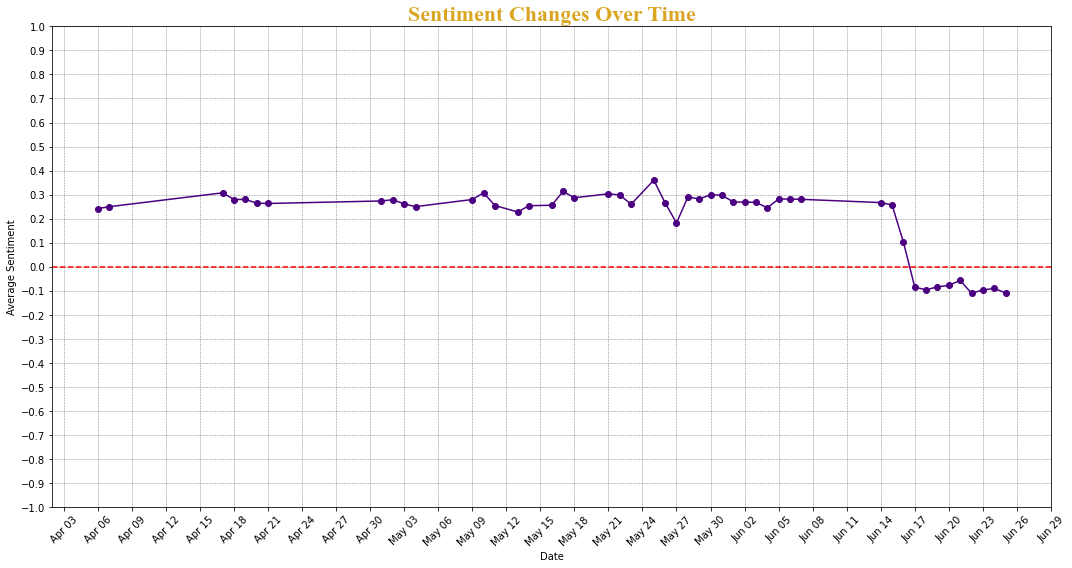

In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Date Conversion to datetime format
df['date'] = pd.to_datetime(df['date'])
# Extracting date from the timestamp
df['date'] = df['date'].dt.date

# Mapping sentiment to numerical values
sentiment_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}
df['sentiment_value'] = df['sentiment'].map(sentiment_mapping)

# Groupping by date & Calculating the average sentiment
date_grouped = df.groupby('date')['sentiment_value'].mean()

# Sentiment Changes over time
plt.figure(figsize=(15, 8))
plt.plot(date_grouped.index, date_grouped.values, marker='o',color='indigo')
plt.title('Sentiment Changes Over Time',color= "goldenrod", fontsize=22,weight='bold',fontname="Times New Roman")
plt.xlabel('Date')
plt.ylabel('Average Sentiment')

plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Formatting x-axis tick as "month day" format with 3 day interval
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))

# Setting y-axis tick interval to 0.1
plt.yticks([i/10 for i in range(-10, 11)])

# Horizontal line at y=0 (Neutral Zone)
plt.axhline(y=0, color='red', linestyle='--')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As seen above the overall Sentiment of the tweets are positive up to around **June 17th** from which point they remain negative.

# Forecasting

In [ ]:
%bg yellow
"*TO CONTINUE!!!*"